# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import col,isnan, when, count, concat, lit, avg
from pyspark.sql.functions import countDistinct
from pyspark.ml import Pipeline

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F
from pyspark.sql.functions import variance
from operator import add
from functools import reduce
# from pyspark.sql import functions as F

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

import datetime

# https://aws.amazon.com/blogs/big-data/install-python-libraries-on-a-running-cluster-with-emr-notebooks/

sc.install_pypi_package("pandas==1.0.5") #Install pandas version 1.0.5 
sc.install_pypi_package("matplotlib", "https://pypi.org/simple") #Install matplotlib from given PyPI repository

import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1676218098777_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- ----------
aws-cfn-bootstrap          2.0
beautifulsoup4             4.9.3
boto                       2.49.0
click                      8.1.3
cycler                     0.11.0
docutils                   0.14
fonttools                  4.38.0
jmespath                   1.0.1
joblib                     1.2.0
kiwisolver                 1.4.4
lockfile                   0.11.0
lxml                       4.9.1
matplotlib                 3.5.3
mysqlclient                1.4.2
nltk                       3.7
nose                       1.3.4
numpy                      1.20.0
packaging                  23.0
pandas                     1.0.5
Pillow                     9.4.0
pip                        20.2.2
py-dateutil                2.2
pyparsing                  3.0.9
pystache                   0.5.4
python-daemon              2.2.3
python-dateutil            2.8.2
python37-sagemaker-pyspark 1.4.2
pytz                       2022.6
PyYA

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Read in full sparkify dataset
# event_data = "mini_sparkify_event_data.json"
# Full dataset:
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')

In [5]:
pd.set_option('max_columns', None) # Show all columns
# pd.reset_option(“max_columns”) # Reset number of columns shown

# pd.set_option(“max_colwidth”, None) # Increase column width to show all characters

pd.set_option("max_rows", None) # Show all rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [6]:
df.limit(10).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                              artist       auth firstName  \
0                                          Popol Vuh  Logged In     Shlok   
1                                        Los Bunkers  Logged In   Vianney   
2                                               Lush  Logged In      Vina   
3  Barry Tuckwell/Academy of St Martin-in-the-Fie...  Logged In    Andres   
4                                                Yes  Logged In   Aaliyah   
5                                               MGMT  Logged In      Ryan   
6                                  Animal Collective  Logged In     Isaac   
7                                             Eminem  Logged In  Jonathan   
8                                        Leona Lewis  Logged In  Jennifer   
9                                    The Cranberries  Logged In   Michael   

  gender  itemInSession  lastName      length level  \
0      M            278   Johnson   524.32934  paid   
1      F              9    Miller   238.39

In [7]:
print('Number of rows =', df.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows = 26259199

#### Check for duplicates

In [7]:
# Check for duplicates
if df.count() == df.dropDuplicates().count():
    print('No duplicates are found in the dataset')
else:
    print('There are duplicates found in the dataset')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

No duplicates are found in the dataset

#### Check for NAN and NULL

In [8]:
# Check for NAN
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(artist=0, auth=0, firstName=0, gender=0, itemInSession=0, lastName=0, length=0, level=0, location=0, method=0, page=0, registration=0, sessionId=0, song=3, status=0, ts=0, userAgent=0, userId=0)]

In [9]:
# Check for NULL
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(artist=5408927, auth=0, firstName=778479, gender=778479, itemInSession=0, lastName=778479, length=5408927, level=0, location=778479, method=0, page=0, registration=778479, sessionId=0, song=5408927, status=0, ts=0, userAgent=778479, userId=0)]

In [10]:
# Check for page visits where artist is null
df.filter(col('artist').isNull()).select('page').distinct().collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(page='Downgrade'), Row(page='Save Settings'), Row(page='Error'), Row(page='Add to Playlist'), Row(page='Help'), Row(page='Submit Upgrade'), Row(page='Cancel'), Row(page='Submit Downgrade'), Row(page='Thumbs Down'), Row(page='Home'), Row(page='Roll Advert'), Row(page='About'), Row(page='Upgrade'), Row(page='Cancellation Confirmation'), Row(page='Submit Registration'), Row(page='Login'), Row(page='Register'), Row(page='Thumbs Up'), Row(page='Logout'), Row(page='Settings'), Row(page='Add Friend')]

In [11]:
# Check for unique page where artist is not null
df.select('page').distinct().subtract(df.filter(col('artist').isNull()).select('page').distinct()).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(page='NextSong')]

From the above filtered pages, it can be seen that no artist or songs are recorded because the user is visiting other pages that does not play any song. In this case, it is worth keeping these rows for the algorithm to study the user's behaviour based on page visits. 

In [12]:
# Check for userId
df.select("userId").dropDuplicates().sort("userId").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+
| userId|
+-------+
|1000025|
|1000035|
|1000083|
|1000103|
|1000164|
|1000168|
|1000182|
|1000194|
|1000214|
|1000233|
|1000244|
|1000248|
|1000280|
|1000353|
|1000407|
|1000409|
|1000446|
|1000503|
|1000527|
|1000611|
+-------+
only showing top 20 rows

The dataset is ready to be used.

In [13]:
df_valid = df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Check for total number of users vs total number of users who churned

In [14]:
# Total number of users:
print('Total number of users =',df_valid.select("userId").dropDuplicates().count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total number of users = 22278

In [15]:
# Total number of users vs users who churned
total_users = df_valid.select("userId").dropDuplicates().count()
total_users_churned = df_valid.select(["*"]).where(df_valid.page == "Cancellation Confirmation").count()
total_users_not_churned = total_users - total_users_churned

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
print('Total Users Churned =', total_users_churned)
print('Total Users Not Churned =', total_users_not_churned)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Users Churned = 5003
Total Users Not Churned = 17275

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

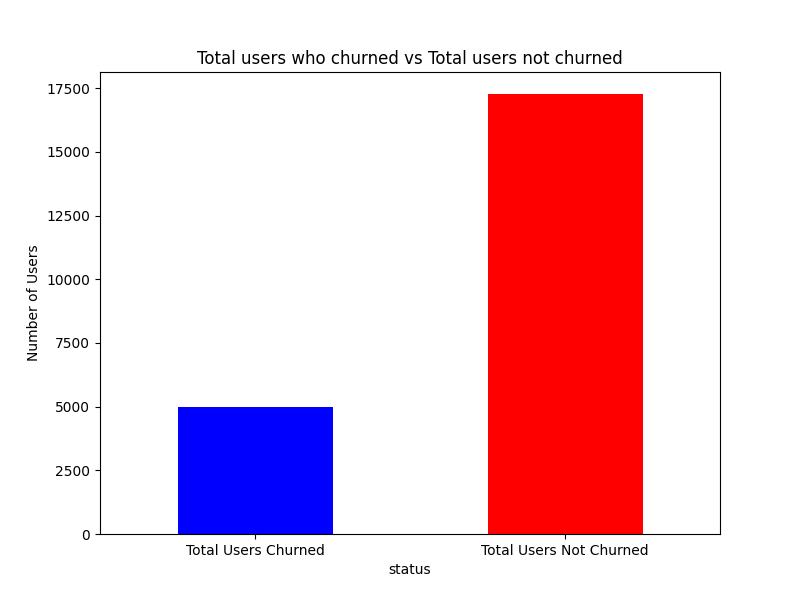

In [52]:
df_churn = spark.createDataFrame([['Total Users Churned',total_users_churned],['Total Users Not Churned',total_users_not_churned]], ['status','count']).toPandas()
plt.clf()
df_churn.plot(kind='bar', x='status',y='count', color=['b','r'], rot = 00,legend=None, figsize=(8,6))
plt.title('Total users who churned vs Total users not churned')
plt.xlabel('status')
plt.ylabel('Number of Users')
%matplot plt

Based on the bar chart above, we can see that the data is imbalanced between users who churned and users who did not churn. Care will need to be taken when preparing the data for machine learning algorithm and evaluation of the results. 

#### Check for gender distribution

In [18]:
df_valid_gender = df_valid.select("userId","gender").dropDuplicates()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
df_valid_female = df_valid_gender.where(df_valid_gender.gender == 'F').count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
df_valid_male = df_valid_gender.where(df_valid_gender.gender == 'M').count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
print('Number of Male Users =', df_valid_male)
print('Number of Female Users =', df_valid_female)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of Male Users = 11651
Number of Female Users = 10626

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

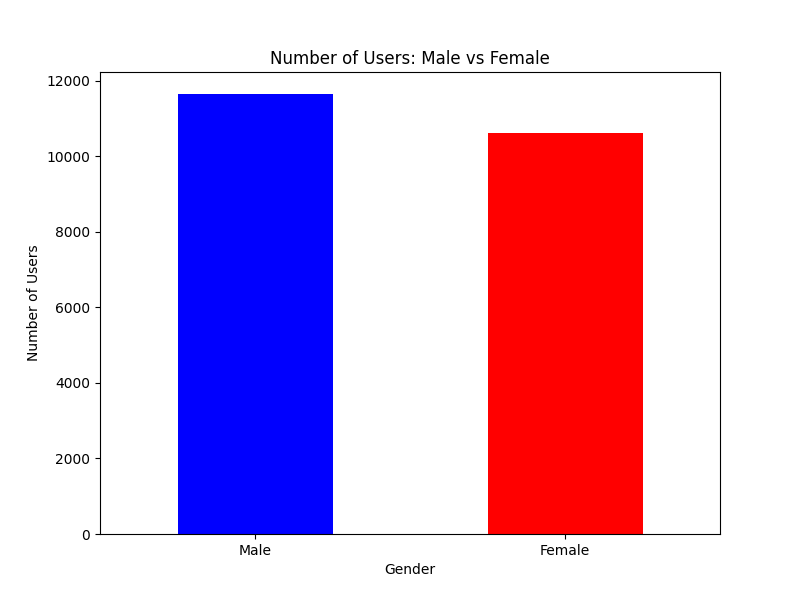

In [53]:
df_m_f = spark.createDataFrame([['Male',df_valid_male],['Female',df_valid_female]], ['Gender','Count']).toPandas()
plt.clf()
df_m_f.plot(kind='bar', x='Gender',y='Count', color=['b','r'], rot = 0, legend=None, figsize=(8,6))
# plt.xticks(df_valid_page_count.page)
# plt.xlim(1995, 2015)
plt.title('Number of Users: Male vs Female')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
%matplot plt

#### Check for average number of page visits per user (Total pages divide by total users)

In [23]:
df_valid_page_count = df_valid.cube("page").count()
df_valid_page_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+
|                page|   count|
+--------------------+--------+
|              Cancel|    5003|
|               Login|  296350|
|             Upgrade|   50507|
|         Roll Advert|  385212|
|     Add to Playlist|  597921|
|                Help|  155100|
|            Settings|  147074|
|           Thumbs Up| 1151465|
|    Submit Downgrade|    6494|
|               About|   92759|
|         Thumbs Down|  239212|
|                Home| 1343102|
|               Error|   25962|
|Cancellation Conf...|    5003|
|              Logout|  296005|
|                null|26259199|
|           Downgrade|  184240|
|      Submit Upgrade|   15135|
|            NextSong|20850272|
|            Register|     802|
+--------------------+--------+
only showing top 20 rows

In [24]:
# Drop Null page
df_valid_page_count = df_valid_page_count.where(df_valid_page_count.page != 'null')
df_valid_page_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+
|                page|   count|
+--------------------+--------+
|              Cancel|    5003|
|               Login|  296350|
|             Upgrade|   50507|
|         Roll Advert|  385212|
|     Add to Playlist|  597921|
|                Help|  155100|
|            Settings|  147074|
|           Thumbs Up| 1151465|
|    Submit Downgrade|    6494|
|               About|   92759|
|         Thumbs Down|  239212|
|                Home| 1343102|
|               Error|   25962|
|Cancellation Conf...|    5003|
|              Logout|  296005|
|           Downgrade|  184240|
|      Submit Upgrade|   15135|
|            NextSong|20850272|
|            Register|     802|
|       Save Settings|   29516|
+--------------------+--------+
only showing top 20 rows

In [25]:
total_users = df_valid.select("userId").dropDuplicates().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
df_valid_page_count = df_valid_page_count.withColumn("count",col("count")/total_users)
df_valid_page_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+
|                page|              count|
+--------------------+-------------------+
|              Cancel|0.22457132597181076|
|               Login|    13.302361073705|
|             Upgrade| 2.2671245174611725|
|         Roll Advert|  17.29113924050633|
|     Add to Playlist| 26.839078911931054|
|                Help|  6.962025316455696|
|            Settings|  6.601759583445552|
|           Thumbs Up| 51.686192656432354|
|    Submit Downgrade| 0.2914983391686866|
|               About| 4.1637041027022175|
|         Thumbs Down|  10.73758865248227|
|                Home|  60.28826645120747|
|               Error| 1.1653649340156207|
|Cancellation Conf...|0.22457132597181076|
|              Logout| 13.286874943890833|
|           Downgrade|  8.270042194092827|
|      Submit Upgrade| 0.6793697818475626|
|            NextSong|  935.9130981237095|
|            Register|0.03599964090133764|
|       Save Settings| 1.3248945147679325|
+----------

In [27]:
df_valid_page_count.toPandas().plot.bar(x='page', y='count') 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:xlabel='page'>

In [28]:
# Drop NextSong page
df_valid_page_count = df_valid_page_count.where(df_valid_page_count.page != 'NextSong')
df_valid_page_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+
|                page|              count|
+--------------------+-------------------+
|              Cancel|0.22457132597181076|
|               Login|    13.302361073705|
|             Upgrade| 2.2671245174611725|
|         Roll Advert|  17.29113924050633|
|     Add to Playlist| 26.839078911931054|
|                Help|  6.962025316455696|
|            Settings|  6.601759583445552|
|           Thumbs Up| 51.686192656432354|
|    Submit Downgrade| 0.2914983391686866|
|               About| 4.1637041027022175|
|         Thumbs Down|  10.73758865248227|
|                Home|  60.28826645120747|
|               Error| 1.1653649340156207|
|Cancellation Conf...|0.22457132597181076|
|              Logout| 13.286874943890833|
|           Downgrade|  8.270042194092827|
|      Submit Upgrade| 0.6793697818475626|
|            Register|0.03599964090133764|
|       Save Settings| 1.3248945147679325|
| Submit Registration|0.01799982045066882|
+----------

In [ ]:
df_valid_page_count.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

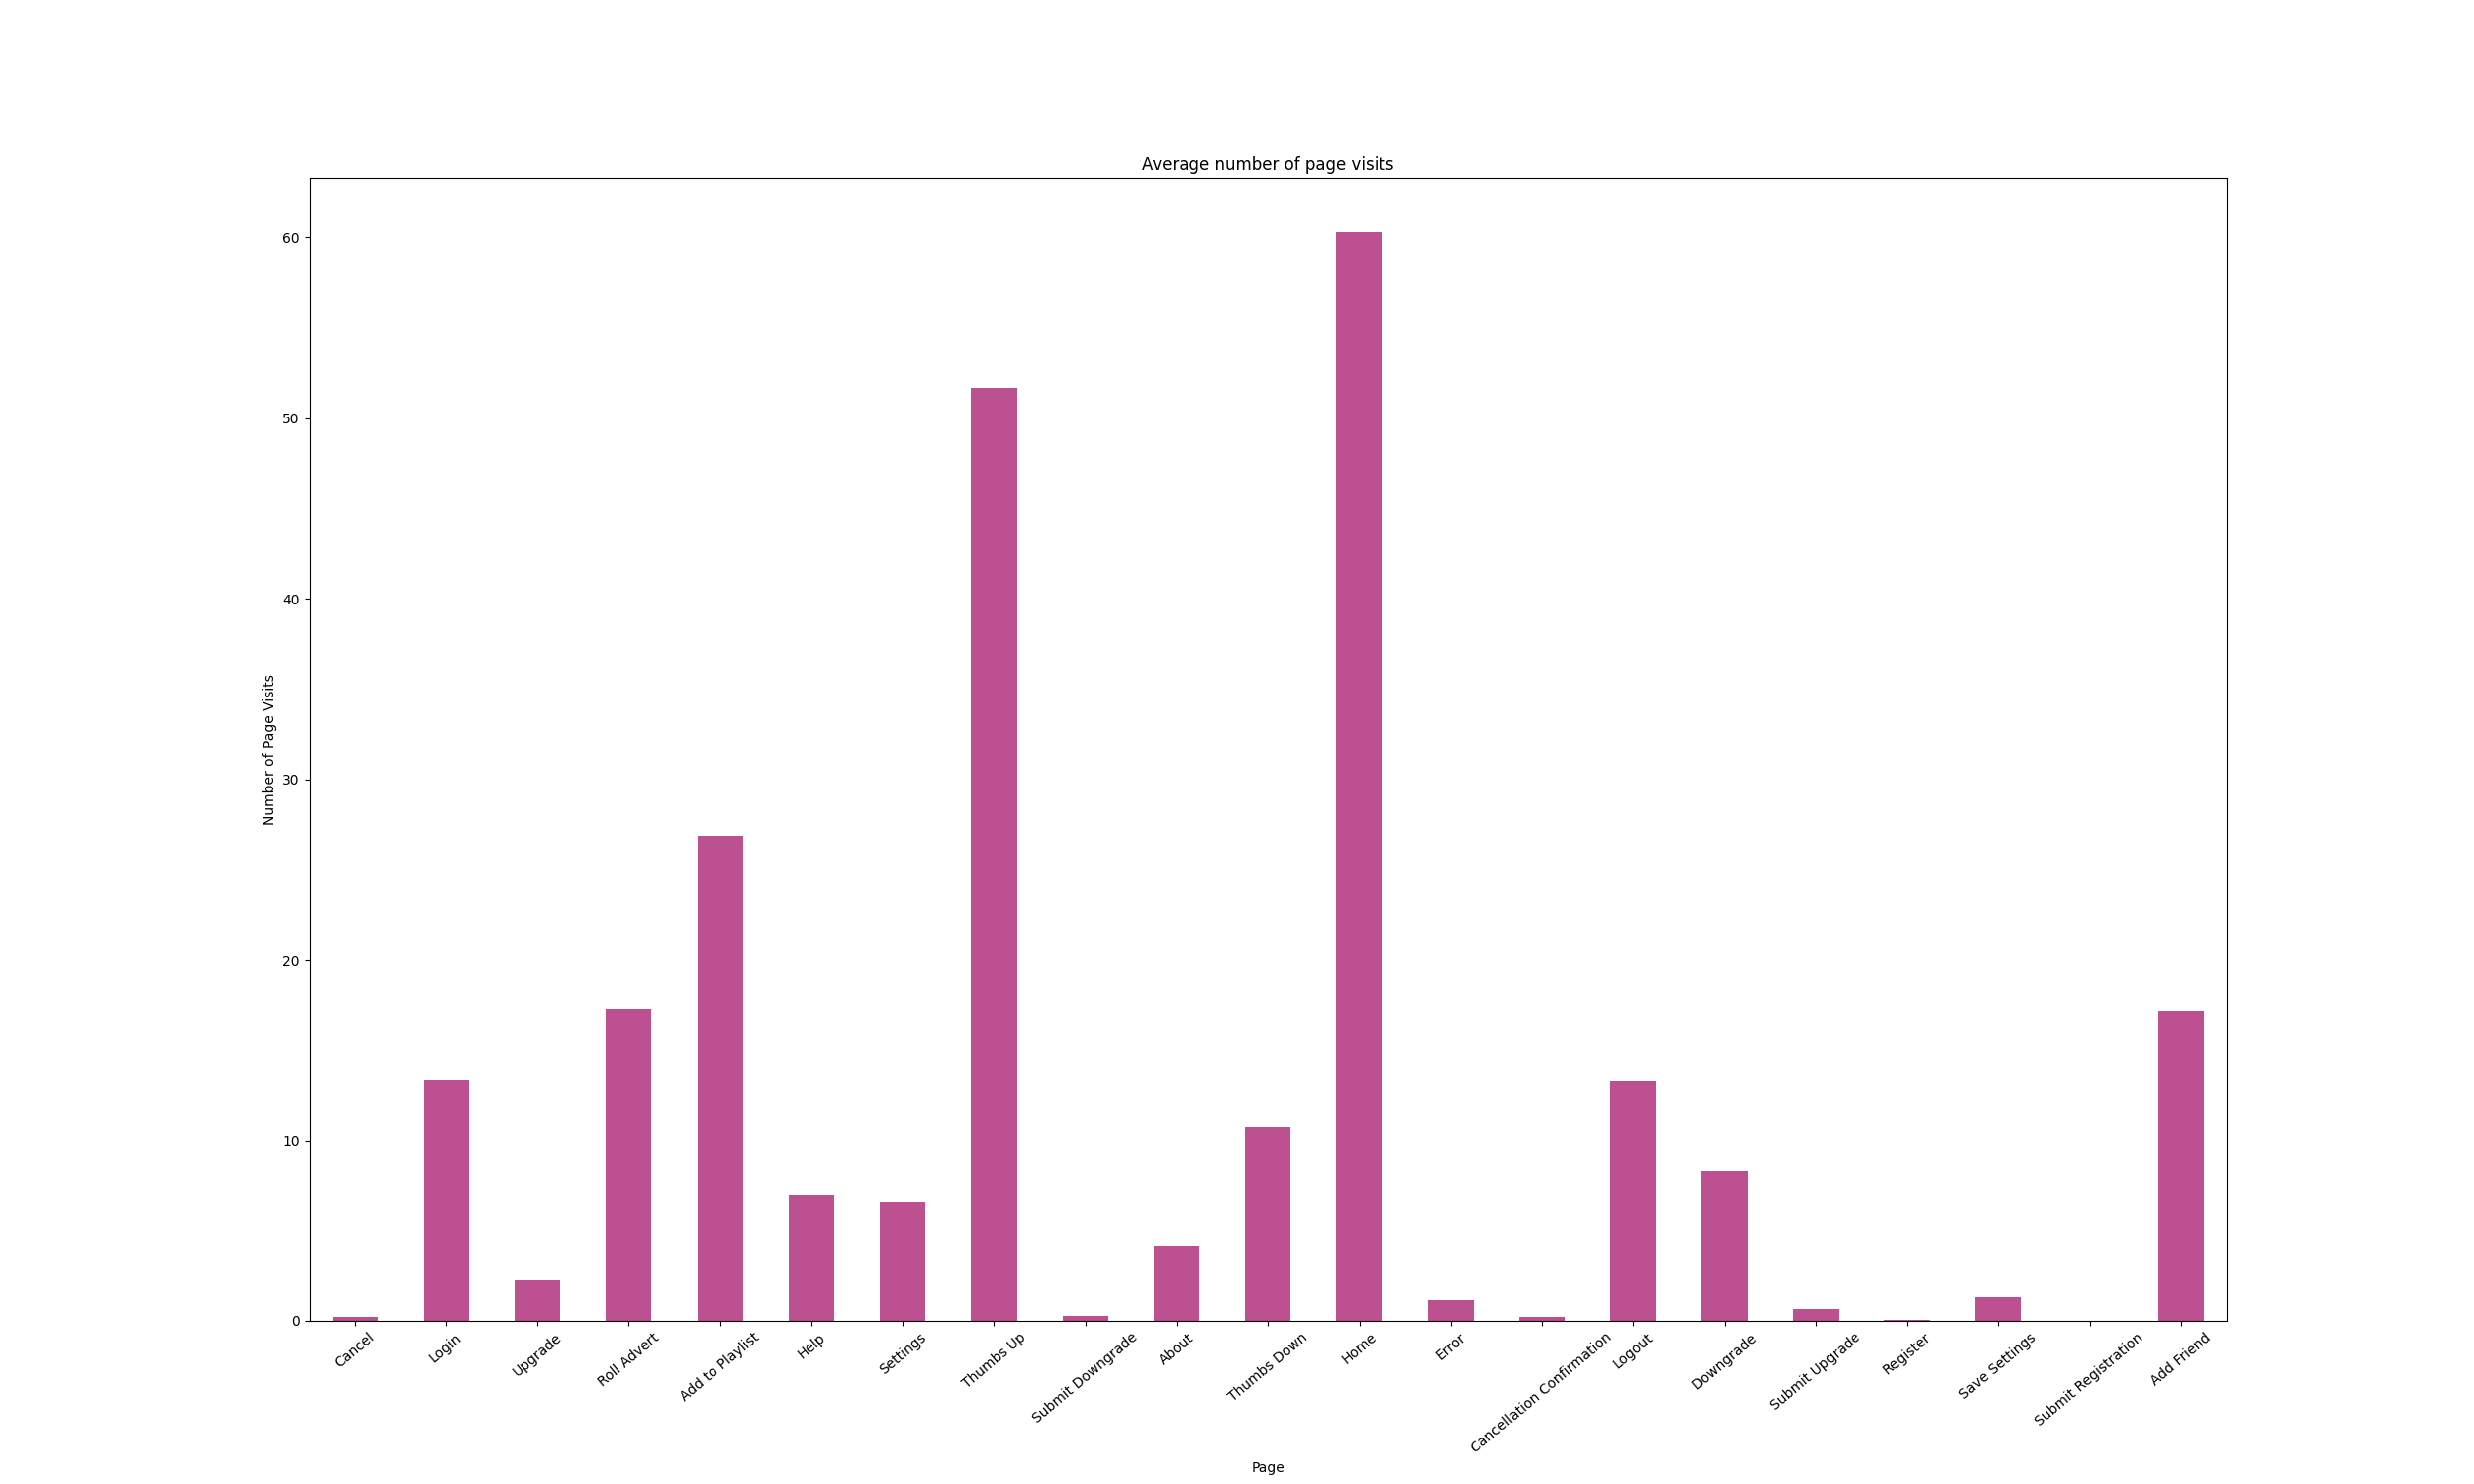

In [65]:
plt.clf()
df_valid_page_count.toPandas().plot(kind='bar', x='page',y='count', color='#bc5090', rot = 40, legend=None, figsize=(25,15))
plt.title('Average number of page visits')
plt.xlabel('Page')
plt.ylabel('Number of Page Visits')
%matplot plt

#### Assumption

Users' page visit varies a lot depending on the type of pages. Type of page visited by users may be one of the important features to be used for the machine learning algorithm to understand more on the user's behaviour. 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Calculating Statistics by Day and Week

In [41]:
# get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_week = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).isocalendar()[1])
get_dayweek = udf(lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0).isocalendar()[2])+"/"+str(datetime.datetime.fromtimestamp(x / 1000.0).isocalendar()[1]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
# Date of registration
df_valid = df_valid.withColumn("day_registration", get_day(df_valid.registration).cast(IntegerType()))
df_valid = df_valid.withColumn("week_registration", get_week(df_valid.registration).cast(IntegerType()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
# df_valid = df_valid.withColumn("hour", get_hour(df_valid.ts))
df_valid = df_valid.withColumn("day", get_day(df_valid.ts).cast(IntegerType()))
df_valid = df_valid.withColumn("week", get_week(df_valid.ts).cast(IntegerType()))
df_valid = df_valid.withColumn("day/week", get_dayweek(df_valid.ts))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
# Create column of how long since user registered
df_valid = df_valid.withColumn("week_since_register", (df_valid.week - df_valid.week_registration))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Assumptions

To simplify the dataframe for Machine Learning Algorithm, the following columns are assumed to not play a role in detecting users behaviour whether they will churn or not:

In [45]:
col_drop = ('artist','auth','firstName','gender','lastName','location','method','sessionId','song','status','userAgent','registration','ts','length')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Remove unnecessary columns

In [46]:
# Drop columns in dataframe
df_valid = df_valid.drop(*col_drop)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
df_valid.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- itemInSession: long (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- day_registration: integer (nullable = true)
 |-- week_registration: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- day/week: string (nullable = true)
 |-- week_since_register: integer (nullable = true)

Create new features using windows udf. Count number of page visits. 

In [48]:
# Create list of columns
pages = df_valid.select("page").dropDuplicates().sort("page").toPandas()

# Iterate each column and convert each page to integer 
for i in pages['page']:
    flag = udf(lambda x: 1 if x == i else 0, IntegerType())
    df_valid = df_valid.withColumn("page_" + i, flag("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
# Calculate sum of page visits for each user
df_1 = df_valid.groupBy("userId").sum('page_About', 'page_Add Friend',
                                          'page_Add to Playlist', 'page_Cancel', 'page_Cancellation Confirmation',
                                          'page_Downgrade', 'page_Error', 'page_Help', 'page_Home', 'page_Logout',
                                          'page_NextSong', 'page_Roll Advert', 'page_Save Settings',
                                          'page_Settings', 'page_Submit Downgrade', 'page_Submit Upgrade',
                                          'page_Thumbs Down', 'page_Thumbs Up', 'page_Upgrade')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Calculate Variance of page for each userId

References:

https://datascienceparichay.com/article/pyspark-variance-of-dataframe-column/

https://stackoverflow.com/questions/31960750/pyspark-dataframe-groupby-and-compute-variance-of-a-column

https://www.analyticsvidhya.com/blog/2021/11/introduction-to-aggregation-functions-in-apache-spark/

In [50]:
# Sum all page count for each day, for each user
df_var = df_valid.groupBy(["userId","day/week"]).sum('page_About', 'page_Add Friend',
                                          'page_Add to Playlist', 'page_Cancel', 'page_Cancellation Confirmation',
                                          'page_Downgrade', 'page_Error', 'page_Help', 'page_Home', 'page_Logout',
                                          'page_NextSong', 'page_Roll Advert', 'page_Save Settings',
                                          'page_Settings', 'page_Submit Downgrade', 'page_Submit Upgrade',
                                          'page_Thumbs Down', 'page_Thumbs Up', 'page_Upgrade').sort(desc("userId"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
# Extract list of column names from df_var
numeric_col_list = ['sum(page_About)',
 'sum(page_Add Friend)',
 'sum(page_Add to Playlist)',
 'sum(page_Cancel)',
 'sum(page_Cancellation Confirmation)',
 'sum(page_Downgrade)',
 'sum(page_Error)',
 'sum(page_Help)',
 'sum(page_Home)',
 'sum(page_Logout)',
 'sum(page_NextSong)',
 'sum(page_Roll Advert)',
 'sum(page_Save Settings)',
 'sum(page_Settings)',
 'sum(page_Submit Downgrade)',
 'sum(page_Submit Upgrade)',
 'sum(page_Thumbs Down)',
 'sum(page_Thumbs Up)',
 'sum(page_Upgrade)']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
# Sum all page counts for each day, for each user
df_var = df_var.withColumn('total_pages', sum([F.col(c) for c in numeric_col_list]))
df_var = df_var.select('userId', 'total_pages')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
# Calculate the variance for each user
df_var = df_var.groupby('userId').agg(variance('total_pages').alias('var_total_pages'))
df_var.limit(10).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    userId  var_total_pages
0  1999996      1644.062500
1  1999908      2905.168347
2  1999905      1006.769231
3  1999892      2808.694444
4  1999848      2517.458669
5  1999847      5313.800000
6  1999781      9283.938462
7  1999720     13242.746439
8  1999691      6279.382353
9  1999668              NaN

Drop page_Cancel because it has the same page visit as page_Cancellation Confirmation

Create another dataframe that counts the total number of days per user. Then calculate the average page visit per person (Excluding cancellation confirmation which will be used as target feature)

In [54]:
# Count the total number of days for each user
df_2 = df_valid.groupBy("userId").agg(countDistinct('day/week').alias('total_days'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
# Join the number of days to the dataframe
df_ml = df_1.join(df_2, ['userId'], how = 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
cols = df_ml.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
cols

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['userId', 'sum(page_About)', 'sum(page_Add Friend)', 'sum(page_Add to Playlist)', 'sum(page_Cancel)', 'sum(page_Cancellation Confirmation)', 'sum(page_Downgrade)', 'sum(page_Error)', 'sum(page_Help)', 'sum(page_Home)', 'sum(page_Logout)', 'sum(page_NextSong)', 'sum(page_Roll Advert)', 'sum(page_Save Settings)', 'sum(page_Settings)', 'sum(page_Submit Downgrade)', 'sum(page_Submit Upgrade)', 'sum(page_Thumbs Down)', 'sum(page_Thumbs Up)', 'sum(page_Upgrade)', 'total_days']

In [58]:
for i in cols:
    df_ml = df_ml.withColumn(i+'_avg', df_ml[i] / df_ml['total_days'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
# Join the variance to the dataframe
df_ml = df_ml.join(df_var, ['userId'], how = 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
# Replace NAN with 0. 
df_ml = df_ml.fillna(value=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Remove unnecessary columns and rearrange columns.

In [61]:
df_ml = df_ml.select(['sum(page_About)_avg',
 'sum(page_Add Friend)_avg',
 'sum(page_Add to Playlist)_avg',
 'sum(page_Downgrade)_avg',
 'sum(page_Error)_avg',
 'sum(page_Help)_avg',
 'sum(page_Home)_avg',
 'sum(page_Logout)_avg',
 'sum(page_NextSong)_avg',
 'sum(page_Roll Advert)_avg',
 'sum(page_Save Settings)_avg',
 'sum(page_Settings)_avg',
 'sum(page_Submit Downgrade)_avg',
 'sum(page_Submit Upgrade)_avg',
 'sum(page_Thumbs Down)_avg',
 'sum(page_Thumbs Up)_avg',
 'sum(page_Upgrade)_avg', 'var_total_pages', col("sum(page_Cancellation Confirmation)").alias("label")])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
df_ml.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['sum(page_About)_avg', 'sum(page_Add Friend)_avg', 'sum(page_Add to Playlist)_avg', 'sum(page_Downgrade)_avg', 'sum(page_Error)_avg', 'sum(page_Help)_avg', 'sum(page_Home)_avg', 'sum(page_Logout)_avg', 'sum(page_NextSong)_avg', 'sum(page_Roll Advert)_avg', 'sum(page_Save Settings)_avg', 'sum(page_Settings)_avg', 'sum(page_Submit Downgrade)_avg', 'sum(page_Submit Upgrade)_avg', 'sum(page_Thumbs Down)_avg', 'sum(page_Thumbs Up)_avg', 'sum(page_Upgrade)_avg', 'var_total_pages', 'label']

In [63]:
df_ml.limit(10).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   sum(page_About)_avg  sum(page_Add Friend)_avg  \
0             0.050000                  1.050000   
1             0.350000                  2.400000   
2             0.200000                  1.600000   
3             0.000000                  0.529412   
4             0.153846                  2.961538   
5             0.000000                  0.666667   
6             0.083333                  1.500000   
7             0.000000                  1.000000   
8             0.312500                  1.437500   
9             0.000000                  0.750000   

   sum(page_Add to Playlist)_avg  sum(page_Downgrade)_avg  \
0                       1.950000                 0.300000   
1                       3.425000                 1.100000   
2                       1.900000                 0.000000   
3                       1.176471                 0.000000   
4                       2.653846                 0.846154   
5                       2.000000                 0.666667   


Important note: Swap label value from positive class from 1 to 0 and negative class from 0 to 1 because Multiclass Evaluator has default metricLabel set to 0. 

https://stackoverflow.com/questions/68236058/how-to-specify-positive-class-in-sparkml-classification

In [64]:
df_ml_2 = df_ml
df_ml_2 = df_ml_2.withColumn('label', when(df_ml_2.label == 0, 2).otherwise(df_ml_2.label))
df_ml_2 = df_ml_2.withColumn('label', when(df_ml_2.label == 1, 0).otherwise(df_ml_2.label))
df_ml_2 = df_ml_2.withColumn('label', when(df_ml_2.label == 2, 1).otherwise(df_ml_2.label))
df_ml_2.limit(10).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   sum(page_About)_avg  sum(page_Add Friend)_avg  \
0             0.000000                  1.000000   
1             0.000000                  0.529412   
2             0.250000                  1.583333   
3             0.190476                  1.190476   
4             0.153846                  2.961538   
5             0.312500                  1.437500   
6             0.200000                  1.500000   
7             0.133333                  1.266667   
8             0.292683                  1.926829   
9             0.294118                  1.470588   

   sum(page_Add to Playlist)_avg  sum(page_Downgrade)_avg  \
0                       1.666667                 1.333333   
1                       1.176471                 0.000000   
2                       1.083333                 0.833333   
3                       3.142857                 0.952381   
4                       2.653846                 0.846154   
5                       2.812500                 0.937500   


Next step to convert all features to vector using VectorAssembler and standardize using StandardScaler.

In [65]:
col_feature = df_ml_2.select(['sum(page_About)_avg',
 'sum(page_Add Friend)_avg',
 'sum(page_Add to Playlist)_avg',
 'sum(page_Downgrade)_avg',
 'sum(page_Error)_avg',
 'sum(page_Help)_avg',
 'sum(page_Home)_avg',
 'sum(page_Logout)_avg',
 'sum(page_NextSong)_avg',
 'sum(page_Roll Advert)_avg',
 'sum(page_Save Settings)_avg',
 'sum(page_Settings)_avg',
 'sum(page_Submit Downgrade)_avg',
 'sum(page_Submit Upgrade)_avg',
 'sum(page_Thumbs Down)_avg',
 'sum(page_Thumbs Up)_avg',
 'sum(page_Upgrade)_avg', 'var_total_pages']).columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
assembler = VectorAssembler(inputCols=col_feature, outputCol="vectorized_features")
df_vector = assembler.transform(df_ml_2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
Scaler=StandardScaler().setInputCol("vectorized_features").setOutputCol("features")
df_scaled = Scaler.fit(df_vector).transform(df_vector)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
df_scaled.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(sum(page_About)_avg=0.05, sum(page_Add Friend)_avg=1.05, sum(page_Add to Playlist)_avg=1.95, sum(page_Downgrade)_avg=0.3, sum(page_Error)_avg=0.05, sum(page_Help)_avg=0.25, sum(page_Home)_avg=2.25, sum(page_Logout)_avg=0.35, sum(page_NextSong)_avg=56.75, sum(page_Roll Advert)_avg=1.0, sum(page_Save Settings)_avg=0.1, sum(page_Settings)_avg=0.4, sum(page_Submit Downgrade)_avg=0.0, sum(page_Submit Upgrade)_avg=0.05, sum(page_Thumbs Down)_avg=0.75, sum(page_Thumbs Up)_avg=3.25, sum(page_Upgrade)_avg=0.2, var_total_pages=3552.1973684210525, label=1, vectorized_features=DenseVector([0.05, 1.05, 1.95, 0.3, 0.05, 0.25, 2.25, 0.35, 56.75, 1.0, 0.1, 0.4, 0.0, 0.05, 0.75, 3.25, 0.2, 3552.1974]), features=DenseVector([0.0103, 1.3562, 1.8543, 0.5682, 0.331, 0.0883, 0.05, 0.7153, 1.7656, 0.5125, 0.798, 1.1332, 0.0, 0.4972, 1.3505, 1.6209, 0.7686, 0.1581]))

In [69]:
# Index labels
# stringOrderType='frequencyAsc' to ensure the most frequent label is set to 1. 
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel", stringOrderType='frequencyAsc').fit(df_scaled)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df_scaled)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## Train Test Split

In [72]:
# Stratified train test split
# https://stackoverflow.com/questions/47637760/stratified-sampling-with-pyspark
df_scaled.groupBy('label').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    1|17275|
|    0| 5003|
+-----+-----+

In [73]:
train = df_scaled.sampleBy("label", fractions={0: 0.8, 1: 0.8}, seed=10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [74]:
test = df_scaled.subtract(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
train.groupBy('label').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    1|13778|
|    0| 4012|
+-----+-----+

In [76]:
test.groupBy('label').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    1| 3511|
|    0|  987|
+-----+-----+

## Oversampling

Due to class imbalance, we would attempt to balance the labels with oversampling. 

Note: Skip this portion to proceed with modeling without oversampling.

Important to note that the oversampling shall only be done on the training set.

In [77]:
major_df = train.filter(col("label") == 1)
minor_df = train.filter(col("label") == 0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [78]:
# Calculate fraction amount to oversample
major_df_count = major_df.count()
minor_df_count =minor_df.count()
fraction_oversample = round((major_df_count - minor_df_count)/minor_df_count, 1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
a = minor_df.sample(True, fraction_oversample, 42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
a.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

9626

In [81]:
train = train.unionAll(a)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
train.groupBy('label').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    1|13818|
|    0|13562|
+-----+-----+

In [83]:
train.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(sum(page_About)_avg=0.0, sum(page_Add Friend)_avg=1.0, sum(page_Add to Playlist)_avg=1.6666666666666667, sum(page_Downgrade)_avg=1.3333333333333333, sum(page_Error)_avg=0.3333333333333333, sum(page_Help)_avg=0.0, sum(page_Home)_avg=1.6666666666666667, sum(page_Logout)_avg=0.0, sum(page_NextSong)_avg=60.333333333333336, sum(page_Roll Advert)_avg=0.0, sum(page_Save Settings)_avg=0.0, sum(page_Settings)_avg=0.0, sum(page_Submit Downgrade)_avg=0.0, sum(page_Submit Upgrade)_avg=0.0, sum(page_Thumbs Down)_avg=0.6666666666666666, sum(page_Thumbs Up)_avg=5.0, sum(page_Upgrade)_avg=0.0, var_total_pages=550.3333333333334, label=0, vectorized_features=SparseVector(18, {1: 1.0, 2: 1.6667, 3: 1.3333, 4: 0.3333, 6: 1.6667, 8: 60.3333, 14: 0.6667, 15: 5.0, 17: 550.3333}), features=SparseVector(18, {1: 1.2916, 2: 1.5849, 3: 2.5255, 4: 2.2065, 6: 0.037, 8: 1.8771, 14: 1.2005, 15: 2.4938, 17: 0.0245}))

In [84]:
# train, test = df_scaled.randomSplit([0.7, 0.3], seed=24)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [85]:
train.select(['*']).columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['sum(page_About)_avg', 'sum(page_Add Friend)_avg', 'sum(page_Add to Playlist)_avg', 'sum(page_Downgrade)_avg', 'sum(page_Error)_avg', 'sum(page_Help)_avg', 'sum(page_Home)_avg', 'sum(page_Logout)_avg', 'sum(page_NextSong)_avg', 'sum(page_Roll Advert)_avg', 'sum(page_Save Settings)_avg', 'sum(page_Settings)_avg', 'sum(page_Submit Downgrade)_avg', 'sum(page_Submit Upgrade)_avg', 'sum(page_Thumbs Down)_avg', 'sum(page_Thumbs Up)_avg', 'sum(page_Upgrade)_avg', 'var_total_pages', 'label', 'vectorized_features', 'features']

## Modeling

References:

Pyspark logistic regression example
https://medium.com/swlh/logistic-regression-with-pyspark-60295d41221

https://spark.apache.org/docs/latest/ml-tuning.html

https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html

https://spark.apache.org/docs/2.2.0/ml-classification-regression.html

Models to test on are:
- Logistic Regression
- Random Forest Classifier
- Gradient Boosting Tree Classifier

Note: Due to the extensive time required to train the machine learning model with hyperparameter tuning, we will only apply hyperparameter tuning to Logistic Regression model as an example. 

## Logistic Regression

## Pipeline with hyperparameter tuning

In [86]:
logr = LogisticRegression(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=30, regParam=0.0, elasticNetParam=0.0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [87]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr, labelConverter])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [88]:
# https://stackoverflow.com/questions/68236058/how-to-specify-positive-class-in-sparkml-classification
evaluator = MulticlassClassificationEvaluator()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
paramGrid = (ParamGridBuilder()
            .addGrid(logr.regParam, [0.0, 0.3])
            .addGrid(logr.elasticNetParam,[0.0, 0.8])
            .build())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [90]:
# Train validation split
tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 90% of the data will be used for training, 10% for validation.
                           trainRatio=0.9, seed = 42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [91]:
tvsModel = tvs.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [92]:
results = tvsModel.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [104]:
preds_and_labels_logr = results.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('label', ascending = False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [105]:
preds_and_labels_logr = preds_and_labels_logr.select(['prediction','label'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [108]:
preds_and_labels_logr.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  1.0|
|       1.0|  1.0|
|       0.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
+----------+-----+
only showing top 20 rows

In [111]:
metrics = MulticlassMetrics(preds_and_labels_logr.rdd.map(tuple))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [113]:
print('Confusion Matrix\n', metrics.confusionMatrix().toArray())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion Matrix
 [[ 609.  404.]
 [ 954. 2532.]]

In [133]:
f1Score_logr = metrics.fMeasure(0.0,2.0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [134]:
print("F1 Score = %s" % f1Score_logr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1 Score = 0.5422974176313445

## Random Forest

In [95]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [96]:
model = pipeline.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [149]:
predictions = model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [164]:
preds_and_labels_rf = predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('label', ascending = False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [165]:
preds_and_labels_rf = preds_and_labels_rf.select(['prediction','label'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [166]:
preds_and_labels_rf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  1.0|
|       1.0|  1.0|
|       0.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  1.0|
|       1.0|  1.0|
+----------+-----+
only showing top 20 rows

In [154]:
metrics = MulticlassMetrics(preds_and_labels_rf.rdd.map(tuple))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [155]:
print('Confusion Matrix\n', metrics.confusionMatrix().toArray())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion Matrix
 [[ 805.  209.]
 [ 282. 3203.]]

In [156]:
f1Score_rf = metrics.fMeasure(0.0,2.0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [157]:
print("F1 Score = %s" % f1Score_rf)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1 Score = 0.7826171495236243

## Gradient Boosted Tree

In [100]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=20, maxDepth = 10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
model = pipeline.fit(train)

# Make predictions.
predictions = model.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [167]:
preds_and_labels_gbt = predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('label', ascending = False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [168]:
preds_and_labels_gbt = preds_and_labels_gbt.select(['prediction','label'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [169]:
preds_and_labels_gbt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
+----------+-----+
only showing top 20 rows

In [158]:
metrics = MulticlassMetrics(preds_and_labels_gbt.rdd.map(tuple))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [159]:
print('Confusion Matrix\n', metrics.confusionMatrix().toArray())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion Matrix
 [[ 785.  215.]
 [ 282. 3212.]]

In [161]:
f1Score_gbt = metrics.fMeasure(0.0,2.0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [162]:
print("F1 Score = %s" % f1Score_gbt)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

F1 Score = 0.7746200907835011

## Conclusion

In [163]:
print('Logistic Regression F1 Score = %s' % f1Score_logr)
print('Random Forest F1 Score = %s' % f1Score_rf)
print('Gradient Boosted Tree F1 Score = %s' % f1Score_gbt)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression F1 Score = 0.5422974176313445
Random Forest F1 Score = 0.7826171495236243
Gradient Boosted Tree F1 Score = 0.7746200907835011

Based on the F1 score of Logistic Regression, Random Forest and Gradient Boosted Tree, we can see that Random Forest obtained the highest F1 score.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

## Future work

Consideration for improvement:
1. To try working with different time window such as only taking 3 weeks of user's activity. The idea is that user's behaviour may change and hence user's activity from long ago may no longer be relevant. 
2. To try other classification models such as Support Vector Machine for comparison. 

### References

https://stackoverflow.com/questions/43287451/divide-pyspark-dataframe-column-by-column-in-other-pyspark-dataframe-when-id-mat
https://mrpowers.medium.com/performing-operations-on-multiple-columns-in-a-pyspark-dataframe-36e97896c378